# Extended Modeling #

In [137]:
# Imports
import json

import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis.gensim

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
# Import processed data as DataFrame
proc_r_df = pd.read_csv('/Users/dwalkerpage/Documents/Data_Science/Springboard/Projects/springboard/Capstone_Projects/Capstone_Project_2/Code/processed_cleaned_restaurants_final.csv')

## 1. Load and Process Data ##

In [10]:
# Load samples

proc_r_df_sample1_000 = pd.read_json('proc_r_df_sample1_000.json')

proc_r_df_sample10_000 = pd.read_json('proc_r_df_sample10_000.json')

proc_r_df_sample100_000 = pd.read_json('proc_r_df_sample100_000.json')

In [30]:
# Function for tokenizing strings in an iterable
def get_tokens(iterable):
    return [string.split() for string in tqdm(iterable, desc='get_tokens')]

In [31]:
# Function to get feature dictionary where the key is the word and value is the number of times that word occurs in the entire corpus of documents
def get_feature_dict(word_tokens):
    return gensim.corpora.Dictionary(word_tokens)

In [32]:
# Function to construct Bag of Words representation of text
def get_bow(feature_dict, word_tokens):
    return [feature_dict.doc2bow(token) for token in tqdm(word_tokens, desc='get_bow')]

In [33]:
# Function to get feature_id to feature mapping (needed to inspect topics later)
def get_id2token(feature_dict):
    temp = feature_dict[0] # initialize feature_dict in memory
    return feature_dict.id2token

In [34]:
# Function to get sample, vectorize text data, and split vector representation into train/test sets
def lda_input(df, test_size=0.3, random_state=7):
    
    tokens = get_tokens(df['text'])
    
    feature_dict = get_feature_dict(tokens)
    
    bow = get_bow(feature_dict, tokens)
    
    id2token_mapping = get_id2token(feature_dict)
    
    xtrain, xtest = train_test_split(bow, test_size=test_size, random_state=random_state)
    
    return tokens, feature_dict, bow, id2token_mapping, xtrain, xtest

In [183]:
# SAMPLE SIZE 1_000

(review_tokens1_000,
 feature_dict1_000,
 bow1_000,
 id2word1_000,
 xtrain1_000,
 xtest1_000) = lda_input(proc_r_df_sample1_000,
                         test_size=0.3,
                         random_state=7
                         )

In [42]:
# SAMPLE SIZE 10_000

(review_tokens10_000,
 feature_dict10_000,
 bow10_000,
 id2word10_000,
 xtrain10_000,
 xtest10_000) = lda_input(proc_r_df_sample10_000,
                         test_size=0.3,
                         random_state=7
                         )

In [43]:
# SAMPLE SIZE 100_000

(review_tokens100_000,
 feature_dict100_000,
 bow100_000,
 id2word100_000,
 xtrain100_000,
 xtest100_000) = lda_input(proc_r_df_sample100_000,
                         test_size=0.3,
                         random_state=7
                         )

## 2. Initial Model Construction and Evaluation ##

The overarching aim of this project is to develop at least one model that can extract informative and human-interpretable topics from Yelp restaurant reviews. Topics are *informative* if they accurately indicate and summarize the content of the reviews. Topics are *human-interpretable* if a competent user of the English language can gain some understanding of the content of reviews by understanding the topics given by the model.

Since we are using an unsupervised approach to develop a model, we need to identify a way to evaluate the performance of a model and to determine the extent to which it meets the project goals. As is made clear in [this talk](https://www.youtube.com/watch?v=UkmIljRIG_M) (and [this](https://github.com/mattilyra/pydataberlin-2017/blob/master/notebook/EvaluatingUnsupervisedModels.ipynb) corresponding notebook), evaluating topic models is difficult. Technical approaches and associated quantitative metrics have been suggested, but research into these approaches and metrics is still nascent. See [this article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) for a helpful overview of current research.

We project that the most useful method of evaluation for the current project will be our judgement of the quality of the model output, and the extent to which it is informative and interpretable. Some refer to this approach as "eyeballing" the model output. It is beyond the scope of the present project to study the various quantitative approaches in depth. Nevertheless, after constructing several initial models, we will evaluate these models using the concept of 'coherence'. Roughly, the coherence of a set of text tokens (whether word, sentence, paragraph, etc.) consists in the extent to which the tokens fit together, hang together, or are mutually relevant to each other. For example, the collection of word tokens `['dog', 'cat', 'hamster', 'bunny']` plausibly form a pretty coherent set, whereas the collection `['dog', 'tissue', 'iphone', 'Kenya']` is not as coherent. There are many different measures of coherence that attempt to quantify this concept. We will use a couple of different coherence metrics to evaluate the topics generated by our initial models. After constructing the initial models and evaluating the coherence of their outputs, we will visually inspect their outputs and then try to construct refined models that perform better.

In [44]:
# Function to construct models

def lda_models(topic_counts,
               corpus,
               id2word,
               chunksize=2000,
               passes=1,
               alpha='symmetric',
               eta=None,
               decay=0.5,
               offset=1.0,
               eval_every=None,
               iterations=50,
               gamma_threshold=0.001,
               minimum_probability=0.01,
               random_state=7
              ):
    models = []
    for topic_count in topic_counts:
        model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=topic_count,
                             workers=5,
                             chunksize=chunksize,
                             passes=passes,
                             batch=False,
                             alpha=alpha,
                             eta=eta,
                             decay=decay,
                             offset=offset,
                             eval_every=eval_every,
                             iterations=iterations,
                             gamma_threshold=gamma_threshold,
                             minimum_probability=minimum_probability,
                             random_state=random_state,
#                              minimum_phi_value=0.01,
#                              per_word_topics=False,
#                              dtype=<class 'numpy.float32'>,
                            )
        models.append(model)

    return models

In [57]:
%%time

# Construct models

topic_counts = [5, 10, 25, 50]

models_1_000 = lda_models(topic_counts, corpus=xtrain1_000, id2word=id2word1_000)

models_10_000 = lda_models(topic_counts, corpus=xtrain10_000, id2word=id2word10_000)

models_100_000 = lda_models(topic_counts, corpus=xtrain100_000, id2word=id2word100_000)

CPU times: user 2min 13s, sys: 23.8 s, total: 2min 37s
Wall time: 1min 16s


In [119]:
# help(CoherenceModel)

In [59]:
# Function to compute coherence scores

def get_coherence(models, texts, corpus, dictionary, coherence='c_v'):
    '''
    models = list of lda models
    texts = id2token mapping
    corpus = documents in BoW format
    dictionary = feature_dict, Gensim dictionary mapping of id word to create corpus
    '''
    output = []
    for model in models:
        coherence_model = CoherenceModel(model=model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence, processes=5)
        coherence_value = coherence_model.get_coherence()
        output.append((coherence_model, coherence_value))
    
    return output

We will compute coherence using the 'u_mass' metric and the 'c_v' metric. It is worthwhile in future work to explore the differences between these metrics (and how they differ from other metrics), but this is beyond the scope of the present project. These two metrics have been selected primarily because 'c_v' is the default metric used in Gensim, and the 'u_mass' metric is considered one of the more computationally efficient metrics to compute.

In [80]:
%%time

umass_train_coherence_1_000 = get_coherence(models_1_000, review_tokens1_000, xtrain1_000, feature_dict1_000, coherence='u_mass')

umass_train_coherence_10_000 = get_coherence(models_10_000, review_tokens10_000, xtrain10_000, feature_dict10_000, coherence='u_mass')

umass_train_coherence_100_000 = get_coherence(models_100_000, review_tokens100_000, xtrain100_000, feature_dict100_000, coherence='u_mass')

umass_test_coherence_1_000 = get_coherence(models_1_000, review_tokens1_000, xtest1_000, feature_dict1_000, coherence='u_mass')

umass_test_coherence_10_000 = get_coherence(models_10_000, review_tokens10_000, xtest10_000, feature_dict10_000, coherence='u_mass')

umass_test_coherence_100_000 = get_coherence(models_100_000, review_tokens100_000, xtest100_000, feature_dict100_000, coherence='u_mass')

CPU times: user 21.4 s, sys: 255 ms, total: 21.6 s
Wall time: 21.7 s


In [207]:
[i[1] for i in umass_train_coherence_1_000]

[-1.3105295779612793,
 -1.3822379152327182,
 -1.6702724970449163,
 -1.872986696391077]

In [91]:
# Function to plot coherence scores

def plot_coherence_scores(topic_counts, coherence_data_list, title=None):
    coherence_1_000 = coherence_data_list[0]
    coherence_10_000 = coherence_data_list[1]
    coherence_100_000 = coherence_data_list[2]
    x = topic_counts
    y1_000 = [i[1] for i in coherence_1_000]
    y10_000 = [i[1] for i in coherence_10_000]
    y100_000 = [i[1] for i in coherence_100_000]
    plt.plot(x, y1_000, 'r', x, y10_000, 'b', x, y100_000, 'g')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Scores')
    plt.title(title)
    plt.legend(['1,000', '10,000', '100,000'], title='Sample Sizes', loc='best')
    return plt.show()

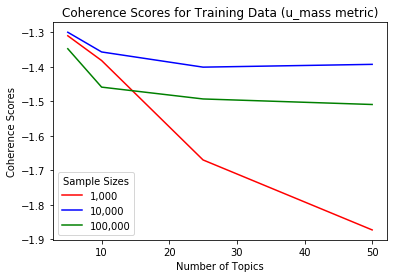

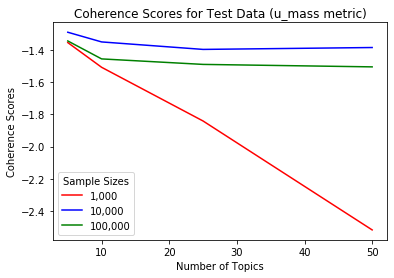

In [92]:
# Plot coherence scores

umass_train_coherence_data_list = [umass_train_coherence_1_000, umass_train_coherence_10_000, umass_train_coherence_100_000]

umass_test_coherence_data_list = [umass_test_coherence_1_000, umass_test_coherence_10_000, umass_test_coherence_100_000]

plot_coherence_scores(topic_counts, umass_train_coherence_data_list, title='Coherence Scores for Training Data (u_mass metric)')

plot_coherence_scores(topic_counts, umass_test_coherence_data_list, title='Coherence Scores for Test Data (u_mass metric)')

In [85]:
%%time

cv_train_coherence_1_000 = get_coherence(models_1_000, review_tokens1_000, xtrain1_000, feature_dict1_000, coherence='c_v')

cv_train_coherence_10_000 = get_coherence(models_10_000, review_tokens10_000, xtrain10_000, feature_dict10_000, coherence='c_v')

cv_train_coherence_100_000 = get_coherence(models_100_000, review_tokens100_000, xtrain100_000, feature_dict100_000, coherence='c_v')

cv_test_coherence_1_000 = get_coherence(models_1_000, review_tokens1_000, xtest1_000, feature_dict1_000, coherence='c_v')

cv_test_coherence_10_000 = get_coherence(models_10_000, review_tokens10_000, xtest10_000, feature_dict10_000, coherence='c_v')

cv_test_coherence_100_000 = get_coherence(models_100_000, review_tokens100_000, xtest100_000, feature_dict100_000, coherence='c_v')

CPU times: user 42.6 s, sys: 5.79 s, total: 48.4 s
Wall time: 3min 2s


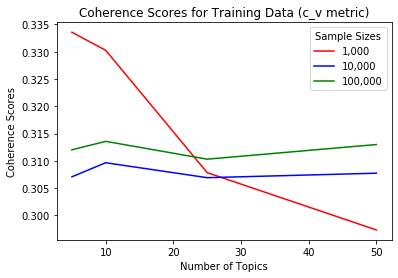

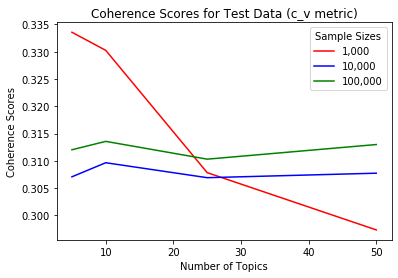

In [86]:
# Plot coherence scores

cv_train_coherence_data_list = [cv_train_coherence_1_000, cv_train_coherence_10_000, cv_train_coherence_100_000]

cv_test_coherence_data_list = [cv_test_coherence_1_000, cv_test_coherence_10_000, cv_test_coherence_100_000]

plot_coherence_scores(topic_counts, cv_train_coherence_data_list, title='Coherence Scores for Training Data (c_v metric)')

plot_coherence_scores(topic_counts, cv_test_coherence_data_list, title='Coherence Scores for Test Data (c_v metric)')

The plots indicate that the models with 5 or 10 topics are at least slightly more coherent than models with more topics. Nonetheless, judging by the recommendations made [here](https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad), the topics are still not very coherent. The u_mass metric ranges from -14 to 14, and the c_v metric ranges from -1 to 1.

Let's construct a table summarizing the coherence results for the training data, and then let's inspect the topics for these models.

In [215]:
u_mass_scores = [i[1] for i in umass_train_coherence_1_000] + [i[1] for i in umass_train_coherence_10_000] + [i[1] for i in umass_train_coherence_100_000]

cv_scores = [i[1] for i in cv_train_coherence_1_000] + [i[1] for i in cv_train_coherence_10_000] + [i[1] for i in cv_train_coherence_100_000]

index_labels = [f'Sample {s}, {t} Topics' for s in ['1_000', '10_000', '100_000'] for t in [5, 10, 25, 50]]

coherence_df = pd.DataFrame(data={'u_mass': u_mass_scores, 'c_v': cv_scores}, index=index_labels)

coherence_df.style.set_caption('Coherence Scores for 12 Initial Models')



,u_mass,c_v
"Sample 1_000, 5 Topics",-1.31053,0.33356
"Sample 1_000, 10 Topics",-1.38224,0.330242
"Sample 1_000, 25 Topics",-1.67027,0.307825
"Sample 1_000, 50 Topics",-1.87299,0.29733
"Sample 10_000, 5 Topics",-1.30027,0.307064
"Sample 10_000, 10 Topics",-1.35739,0.309644
"Sample 10_000, 25 Topics",-1.40139,0.306904
"Sample 10_000, 50 Topics",-1.39331,0.307726
"Sample 100_000, 5 Topics",-1.34807,0.31202
"Sample 100_000, 10 Topics",-1.45927,0.313559


In [130]:
# Function to get topic DataFrame to visually inspect topics

def get_dataframe(model, num_topics, sample_size, num_words):
    df = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)]
              for topic_id, words in model.show_topics(formatted=False, num_words=num_words, num_topics=num_topics)]).transpose()

    return df.style.set_caption(f'Sample: {sample_size}, Number of Topics: {num_topics}, Number of Words: {num_words}')

In [131]:
get_dataframe(models_1_000[0], 5, 1_000, 5)

,0,1,2,3,4
0,go,good,place,food,food
1,good,food,food,good,good
2,get,place,get,get,place
3,place,like,service,great,go
4,order,pizza,great,go,order


In [132]:
get_dataframe(models_1_000[1], 10, 1_000, 5)

,0,1,2,3,4,5,6,7,8,9
0,go,good,place,good,food,good,food,food,place,food
1,good,food,food,get,good,place,good,get,good,like
2,get,place,service,food,time,time,place,place,get,place
3,food,order,go,go,go,food,great,great,like,good
4,wait,chicken,get,order,order,go,get,come,try,get


In [133]:
get_dataframe(models_10_000[0], 5, 10_000, 5)

,0,1,2,3,4
0,food,food,good,food,food
1,good,place,place,go,go
2,get,time,get,good,place
3,place,great,food,service,get
4,like,good,one,great,order


In [134]:
get_dataframe(models_10_000[1], 10, 10_000, 5)

,0,1,2,3,4,5,6,7,8,9
0,food,food,good,food,food,food,food,place,good,place
1,good,order,place,go,go,great,good,time,great,great
2,get,place,get,good,order,service,order,get,place,good
3,place,time,one,order,get,like,great,come,food,food
4,like,good,food,service,place,good,place,good,like,one


In [135]:
get_dataframe(models_100_000[0], 5, 100_000, 5)

,0,1,2,3,4
0,get,food,place,food,good
1,go,place,good,great,food
2,food,time,food,good,place
3,order,go,go,get,get
4,good,come,order,order,like


In [136]:
get_dataframe(models_100_000[1], 10, 100_000, 5)

,0,1,2,3,4,5,6,7,8,9
0,get,food,place,get,good,good,good,go,great,good
1,go,place,food,food,food,get,get,good,food,place
2,table,time,go,order,like,food,food,place,service,food
3,food,come,good,go,place,go,place,service,place,order
4,order,go,order,good,get,one,go,back,good,like


One thing we can see from inspecting these topics is that several words are repeated across nearly all of the topics. We suspect this is because these words are very common in the corpus of documents. Let's see if filtering out words that are especially common in the corpus improves the coherence scores of the models. Let's also filter out words that occur in < 5 documents in the corpus as well.

## 3. Refining Model Construction and Evaluating Refined Models ##

In [167]:
# Function to get sample, vectorize text data, and split vector representation into train/test sets
def filtered_lda_input(df, min_freq=0, max_freq=1.0, test_size=0.3, random_state=7):
    
    tokens = get_tokens(df['text'])
    
    feature_dict = get_feature_dict(tokens)
    
    feature_dict.filter_extremes(no_below=min_freq, no_above=max_freq)
    
    filtered_bow = get_bow(feature_dict, tokens)
    
    filtered_id2token_mapping = get_id2token(feature_dict)
    
    filtered_xtrain, filtered_xtest = train_test_split(filtered_bow, test_size=test_size, random_state=random_state)
    
    return tokens, feature_dict, filtered_bow, filtered_id2token_mapping, filtered_xtrain, filtered_xtest

In [173]:
# SAMPLE SIZE 1_000

(review_tokens1_000,
 filtered_feature_dict1_000,
 filtered_bow1_000,
 filtered_id2word1_000,
 filtered_xtrain1_000,
 filtered_xtest1_000) = filtered_lda_input(proc_r_df_sample1_000,
                                           min_freq=5,
                                           max_freq=0.3,
                                           test_size=0.3,
                                           random_state=7
                                          )

In [174]:
# SAMPLE SIZE 10_000

(review_tokens10_000,
 filtered_feature_dict10_000,
 filtered_bow10_000,
 filtered_id2word10_000,
 filtered_xtrain10_000,
 filtered_xtest10_000) = filtered_lda_input(proc_r_df_sample10_000,
                                  min_freq=5,
                                  max_freq=0.3,
                                  test_size=0.3,
                                  random_state=7
                                 )

In [175]:
# SAMPLE SIZE 100_000

(review_tokens100_000,
 filtered_feature_dict100_000,
 filtered_bow100_000,
 filtered_id2word100_000,
 filtered_xtrain100_000,
 filtered_xtest100_000) = filtered_lda_input(proc_r_df_sample100_000,
                                  min_freq=5,
                                  max_freq=0.3,
                                  test_size=0.3,
                                  random_state=7
                                 )

Now that we've filtered extremes, let's see a before and after comparison for number of features.

In [186]:
print(f'For sample 1_000: Before: {len(feature_dict1_000)}, After: {len(filtered_feature_dict1_000)}')

For sample 1_000: Before: 7205, After: 1525


In [187]:
print(f'For sample 10_000: Before: {len(feature_dict10_000)}, After: {len(filtered_feature_dict10_000)}')

For sample 10_000: Before: 25000, After: 5740


In [188]:
print(f'For sample 100_000: Before: {len(feature_dict100_000)}, After: {len(filtered_feature_dict100_000)}')

For sample 100_000: Before: 96390, After: 19057


We can see that filtering out these extremes removed many features from the datasets. One risk we run by removing so many features is that we might lose information that is important for attaining an accurate summarization with the topics produced by the models. It is worth noting, however, that at least for the 1_000 sample, the vast majority of words removed occurred in less than 5 of the documents. Only 7 words were removed because they occurred in more than 30% of the documents. So most of the words removed were infrequent across documents. Since less frequent words are less important contributors to topics, we can reasonably assume that filtering out these words should not result in less accurate summarization.

Now let's construct new models using the filtered data and evaluate their performance. Since lower topic numbers also seemed to improve coherence scores, let's construct models with 2, 5, 7, and 10 topics.

In [189]:
%%time

# Construct models

topic_counts = [2, 5, 7, 10]

filtered_models_1_000 = lda_models(topic_counts, corpus=filtered_xtrain1_000, id2word=filtered_id2word1_000)

filtered_models_10_000 = lda_models(topic_counts, corpus=filtered_xtrain10_000, id2word=filtered_id2word10_000)

filtered_models_100_000 = lda_models(topic_counts, corpus=filtered_xtrain100_000, id2word=filtered_id2word100_000)

CPU times: user 32.4 s, sys: 7.75 s, total: 40.2 s
Wall time: 48.3 s


In [191]:
%%time

# Compute coherence scores

filtered_umass_train_coherence_1_000 = get_coherence(filtered_models_1_000, review_tokens1_000, filtered_xtrain1_000, filtered_feature_dict1_000, coherence='u_mass')

filtered_umass_train_coherence_10_000 = get_coherence(filtered_models_10_000, review_tokens10_000, filtered_xtrain10_000, filtered_feature_dict10_000, coherence='u_mass')

filtered_umass_train_coherence_100_000 = get_coherence(filtered_models_100_000, review_tokens100_000, filtered_xtrain100_000, filtered_feature_dict100_000, coherence='u_mass')

filtered_umass_test_coherence_1_000 = get_coherence(filtered_models_1_000, review_tokens1_000, filtered_xtest1_000, filtered_feature_dict1_000, coherence='u_mass')

filtered_umass_test_coherence_10_000 = get_coherence(filtered_models_10_000, review_tokens10_000, filtered_xtest10_000, filtered_feature_dict10_000, coherence='u_mass')

filtered_umass_test_coherence_100_000 = get_coherence(filtered_models_100_000, review_tokens100_000, filtered_xtest100_000, filtered_feature_dict100_000, coherence='u_mass')

CPU times: user 8.2 s, sys: 115 ms, total: 8.31 s
Wall time: 8.32 s


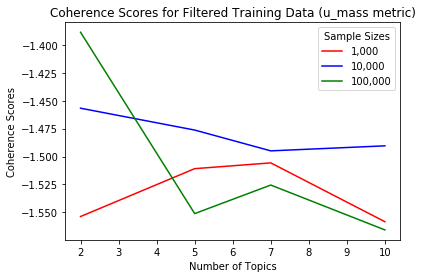

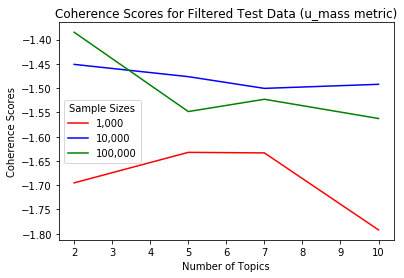

In [196]:
# Plot coherence scores

filtered_umass_train_coherence_data_list = [filtered_umass_train_coherence_1_000, filtered_umass_train_coherence_10_000, filtered_umass_train_coherence_100_000]

filtered_umass_test_coherence_data_list = [filtered_umass_test_coherence_1_000, filtered_umass_test_coherence_10_000, filtered_umass_test_coherence_100_000]

plot_coherence_scores(topic_counts, filtered_umass_train_coherence_data_list, title='Coherence Scores for Filtered Training Data (u_mass metric)')

plot_coherence_scores(topic_counts, filtered_umass_test_coherence_data_list, title='Coherence Scores for Filtered Test Data (u_mass metric)')

In [193]:
%%time

filtered_cv_train_coherence_1_000 = get_coherence(filtered_models_1_000, review_tokens1_000, filtered_xtrain1_000, filtered_feature_dict1_000, coherence='c_v')

filtered_cv_train_coherence_10_000 = get_coherence(filtered_models_10_000, review_tokens10_000, filtered_xtrain10_000, filtered_feature_dict10_000, coherence='c_v')

filtered_cv_train_coherence_100_000 = get_coherence(filtered_models_100_000, review_tokens100_000, filtered_xtrain100_000, filtered_feature_dict100_000, coherence='c_v')

filtered_cv_test_coherence_1_000 = get_coherence(filtered_models_1_000, review_tokens1_000, filtered_xtest1_000, filtered_feature_dict1_000, coherence='c_v')

filtered_cv_test_coherence_10_000 = get_coherence(filtered_models_10_000, review_tokens10_000, filtered_xtest10_000, filtered_feature_dict10_000, coherence='c_v')

filtered_cv_test_coherence_100_000 = get_coherence(filtered_models_100_000, review_tokens100_000, filtered_xtest100_000, filtered_feature_dict100_000, coherence='c_v')

CPU times: user 25 s, sys: 4.69 s, total: 29.7 s
Wall time: 1min 22s


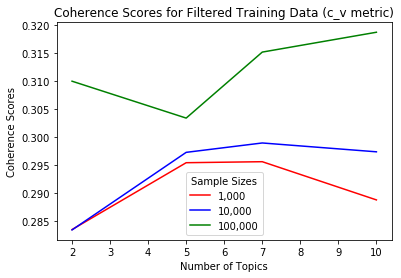

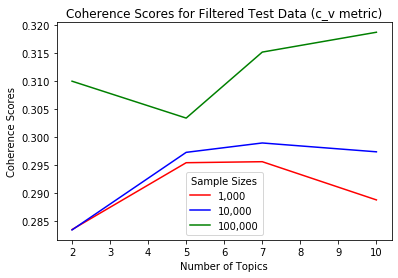

In [195]:
# Plot coherence scores

filtered_cv_train_coherence_data_list = [filtered_cv_train_coherence_1_000, filtered_cv_train_coherence_10_000, filtered_cv_train_coherence_100_000]

filtered_cv_test_coherence_data_list = [filtered_cv_test_coherence_1_000, filtered_cv_test_coherence_10_000, filtered_cv_test_coherence_100_000]

plot_coherence_scores(topic_counts, filtered_cv_train_coherence_data_list, title='Coherence Scores for Filtered Training Data (c_v metric)')

plot_coherence_scores(topic_counts, filtered_cv_test_coherence_data_list, title='Coherence Scores for Filtered Test Data (c_v metric)')

Interestingly, filtering out the words with extreme frequencies appeared to lower the coherence scores, but it improved the relative coherence score of the 100_000 sample model relative to the models with lower samples. Also, it is interesting that two coherence metrics seem to disagree regarding the best number of topics. The u_mass metric suggests the lower number of topics the better, whereas the c_v metric suggests better performance with more topics. According to [this discussion](https://github.com/dice-group/Palmetto/issues/12) this variance might be a general feature of c_v in relation to other metrics.

Let's again construct a table summarizing the coherence results for the filtered training data. Let's also construct a table with the coherence scores for all the models. Then let's visually inspect some of the best performing refined models.

In [216]:
filtered_u_mass_scores = [i[1] for i in filtered_umass_train_coherence_1_000] + [i[1] for i in filtered_umass_train_coherence_10_000] + [i[1] for i in filtered_umass_train_coherence_100_000]

filtered_cv_scores = [i[1] for i in filtered_cv_train_coherence_1_000] + [i[1] for i in filtered_cv_train_coherence_10_000] + [i[1] for i in filtered_cv_train_coherence_100_000]

filtered_index_labels = [f'Filtered Sample {s}, {t} Topics' for s in ['1_000', '10_000', '100_000'] for t in [2, 5, 7, 10]]

filtered_coherence_df = pd.DataFrame(data={'u_mass': filtered_u_mass_scores, 'c_v': filtered_cv_scores}, index=filtered_index_labels)

filtered_coherence_df.style.set_caption('Coherence Scores for 12 Filtered Models')

,u_mass,c_v
"Filtered Sample 1_000, 2 Topics",-1.55387,0.283481
"Filtered Sample 1_000, 5 Topics",-1.51091,0.295406
"Filtered Sample 1_000, 7 Topics",-1.50571,0.295585
"Filtered Sample 1_000, 10 Topics",-1.55852,0.28877
"Filtered Sample 10_000, 2 Topics",-1.45666,0.283417
"Filtered Sample 10_000, 5 Topics",-1.47626,0.297253
"Filtered Sample 10_000, 7 Topics",-1.49493,0.298926
"Filtered Sample 10_000, 10 Topics",-1.49043,0.297349
"Filtered Sample 100_000, 2 Topics",-1.38848,0.309944
"Filtered Sample 100_000, 5 Topics",-1.55123,0.303365


In [219]:
all_coherence_df = pd.concat([coherence_df, filtered_coherence_df])

all_coherence_df.style.set_caption('Coherence Scores for All 24 Models')

,u_mass,c_v
"Sample 1_000, 5 Topics",-1.31053,0.33356
"Sample 1_000, 10 Topics",-1.38224,0.330242
"Sample 1_000, 25 Topics",-1.67027,0.307825
"Sample 1_000, 50 Topics",-1.87299,0.29733
"Sample 10_000, 5 Topics",-1.30027,0.307064
"Sample 10_000, 10 Topics",-1.35739,0.309644
"Sample 10_000, 25 Topics",-1.40139,0.306904
"Sample 10_000, 50 Topics",-1.39331,0.307726
"Sample 100_000, 5 Topics",-1.34807,0.31202
"Sample 100_000, 10 Topics",-1.45927,0.313559


In [223]:
get_dataframe(filtered_models_100_000[0], 2, 100_000, 7)

,0,1
0,like,order
1,order,time
2,come,come
3,one,like
4,love,make
5,time,would
6,chicken,back


In [235]:
# My evaluation of the model

my_eval_2_topics = pd.DataFrame(data={'topic 0': 2, 'topic 1': 3}, index=['Score 1-5:'])

my_eval_2_topics['mean'] = my_eval_2_topics.mean(axis=1)

my_eval_2_topics

,topic 0,topic 1,mean
Score 1-5:,2,3,2.5


In [222]:
get_dataframe(filtered_models_100_000[1], 5, 100_000, 7)

,0,1,2,3,4
0,like,time,order,time,order
1,love,come,come,order,try
2,one,order,drink,come,like
3,come,like,also,restaurant,time
4,order,us,like,one,make
5,chicken,would,time,pizza,nice
6,time,back,make,like,restaurant


In [237]:
# My evaluation of the model

my_eval_5_topics = pd.DataFrame(data={'topic 0': 2, 'topic 1': 3, 'topic 2': 2, 'topic 3': 2, 'topic 4': 2,}, index=['Score 1-5:'])

my_eval_5_topics['mean'] = my_eval_5_topics.mean(axis=1)

my_eval_5_topics

,topic 0,topic 1,topic 2,topic 3,topic 4,mean
Score 1-5:,2,3,2,2,2,2.2


In [226]:
get_dataframe(filtered_models_100_000[2], 7, 100_000, 7)

,0,1,2,3,4,5,6
0,like,time,order,time,order,really,restaurant
1,love,order,come,order,try,one,like
2,come,come,drink,come,like,pizza,well
3,order,us,also,restaurant,burger,like,menu
4,one,like,time,one,time,price,try
5,roll,would,like,say,taco,nice,little
6,time,wait,back,like,make,order,delicious


In [238]:
# My evaluation of the model

my_eval_7_topics = pd.DataFrame(data={'topic 0': 2, 'topic 1': 2, 'topic 2': 2, 'topic 3': 2, 'topic 4': 2, 'topic 5': 2, 'topic 6': 2,}, index=['Score 1-5:'])

my_eval_7_topics['mean'] = my_eval_7_topics.mean(axis=1)

my_eval_7_topics

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,mean
Score 1-5:,2,2,2,2,2,2,2,2.0


In [227]:
get_dataframe(filtered_models_100_000[3], 10, 100_000, 7)

,0,1,2,3,4,5,6,7,8,9
0,roll,time,order,time,order,really,restaurant,try,order,like
1,like,come,come,order,time,one,well,like,fry,come
2,sushi,us,time,come,take,like,menu,make,sandwich,order
3,love,order,drink,restaurant,wait,nice,like,order,chicken,well
4,one,wait,back,say,try,pizza,time,chicken,come,also
5,time,like,say,us,like,time,love,come,burger,try
6,come,would,like,one,burger,ive,little,one,like,would


In [239]:
# My evaluation of the model

my_eval_10_topics = pd.DataFrame(data={'topic 0': 3, 'topic 1': 2, 'topic 2': 2, 'topic 3': 2, 'topic 4': 2, 'topic 5': 2, 'topic 6': 2, 'topic 7': 2, 'topic 8': 4, 'topic 9': 2,}, index=['Score 1-5:'])

my_eval_10_topics['mean'] = my_eval_10_topics.mean(axis=1)

my_eval_10_topics


,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,mean
Score 1-5:,3,2,2,2,2,2,2,2,4,2,2.3


Let's now construct a DataFrame with the coherence scores and my aggregated scores side-by-side.

In [242]:
filtered_u_mass_100_000 = [i[1] for i in filtered_umass_train_coherence_100_000]

filtered_cv_100_000 = [i[1] for i in filtered_cv_train_coherence_100_000]

my_eval_100_000 = [df['mean'].iloc[0] for df in [my_eval_2_topics, my_eval_5_topics, my_eval_7_topics, my_eval_10_topics]]

filtered_100_000_index_labels = [f'Filtered Sample 100_000, {t} Topics' for t in [2, 5, 7, 10]]

filtered_100_000_evaluations = pd.DataFrame(data={'u_mass': filtered_u_mass_100_000, 'c_v': filtered_cv_100_000, 'my evals': my_eval_100_000},
                                            index=filtered_100_000_index_labels
                                           )

filtered_100_000_evaluations.style.set_caption('Evaluations for Filtered Models of Sample Size 100_000')

,u_mass,c_v,my evals
"Filtered Sample 100_000, 2 Topics",-1.38848,0.309944,2.5
"Filtered Sample 100_000, 5 Topics",-1.55123,0.303365,2.2
"Filtered Sample 100_000, 7 Topics",-1.52561,0.315137,2
"Filtered Sample 100_000, 10 Topics",-1.56588,0.318677,2.3


Even though the coherence scores for these models are not necessarily higher than the scores for the unfiltered models, the topics in these models seem somewhat more informative and interpretable.

Let's utilize [pyLDAvis](https://github.com/bmabey/pyLDAvis) to better visualize and inspect some of the models we've constructed.

## 4. Model Visualization ##

### Explanation of Visualizations ###

Background:
LDA generates a probability mass function over all the words in the corpus *for each topic*. In other words, each topic is composed of two parts (1) all of the word tokens in the corpus, and (2) probabilities (i.e. frequencies) associated with the word tokens (one per token). Topics are differentiated by the second of these two components. In order for topics to be distinct, at least one of the probabilities (i.e. frequencies) associated with a word token must differ between the topics.

The visualizations shown below help to represent the following properties of the model output:
* Each circle is a topic.
* Area of circle indicates prevalence of the topic over the corpus. Larger circle indicates greater prevalence.
* Distance between circles approximates (imperfectly because it is a 2-dimensional representation of n-dimensions) the similarity between topics. Smaller distance indicates greater similarity.
* Red bars indicate the frequency of the word in the selected topic.
* Blue bars indicate the frequency of the word across all documents in the corpus.
* The lambda sliding bar determines the weight of the ratio of the red to blue bars. This ratio is the ratio of the frequency of the word given a topic (red bar) over the frequency of the word in the entire corpus (blue bar). Decreasing the value of lambda increasingly shows words whose frequencies within the topic approximates the overall frequency.

### **** Please use [nbviewer](https://nbviewer.jupyter.org/) to view this notebook if you do not see the visualizations. **** ###

In [201]:
# Function to create pyLDAvis visualizations
def get_pyLDAvis(model, bow, feature_dict):
    vis = pyLDAvis.gensim.prepare(model, bow, feature_dict)
    return pyLDAvis.display(vis)

In [202]:
get_pyLDAvis(filtered_models_100_000[0], filtered_bow100_000, filtered_feature_dict100_000)

/Applications/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [203]:
get_pyLDAvis(filtered_models_100_000[1], filtered_bow100_000, filtered_feature_dict100_000)

/Applications/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [204]:
get_pyLDAvis(filtered_models_100_000[2], filtered_bow100_000, filtered_feature_dict100_000)

/Applications/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [205]:
get_pyLDAvis(filtered_models_100_000[3], filtered_bow100_000, filtered_feature_dict100_000)

/Applications/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## 5. Conclusion ##

In total, we have constructed and evaluated 24 models in this notebook. Although the refined models did not have dramatically improved coherence scores, their topic outputs do seem more informative and interpretable. In future work, it would be beneficial to explore more deeply various coherence metrics and various parametrizations of the LDA models to see if we can improve model performance.

### Sources Used for Guidance ###

**Topic Model Evaluation**
* https://www.youtube.com/watch?v=UkmIljRIG_M
* https://github.com/mattilyra/pydataberlin-2017/blob/master/notebook/EvaluatingUnsupervisedModels.ipynb
* https://www.youtube.com/watch?v=rfHCronRgQU
* https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/280375fe14adea67ce6384ba7eabf362b05e6029/docs/notebooks/topic_coherence_tutorial.ipynb
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://stackoverflow.com/questions/11162402/lda-topic-modeling-training-and-testing

**Topic Model Visualization with pyLDAvis**
* https://www.youtube.com/watch?v=SF50IK5XgKA&t=227s
* https://www.youtube.com/watch?v=IksL96ls4o0